In [12]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('../src/')
from Biologging_Toolkit.applications.Rain import Rain
from Biologging_Toolkit.applications.Rain2 import Rain2
from Biologging_Toolkit.applications.Wind import Wind
import Biologging_Toolkit.utils.rain_empirical_utils as R_Utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sklearn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "text.usetex": True  
    })

In [14]:
depids = ['ml17_280a','ml18_296a','ml18_294b','ml19_292a','ml19_292b','ml19_293a','ml19_294a','ml20_293a','ml20_296b','ml20_313a','ml21_295a','ml21_305b']
depids_wo293 = ['ml17_280a','ml18_296a','ml18_294b','ml19_292a','ml19_292b','ml19_293a','ml19_294a','ml20_296b','ml20_313a','ml21_295a','ml21_305b'] #'ml20_293a',

path = 'E:/individus_filtered'
freqs = [500, 1000, 2000, 5000, 8000, 10000, 12000, 15000, 16000]
features_csv = ['downwards_mean_500', 'downwards_mean_1000', 'downwards_mean_2500',
       'downwards_mean_5000', 'downwards_mean_8000', 'downwards_mean_10000',
       'downwards_mean_12000', 'downwards_mean_15000', 'downwards_mean_16000','upwards_mean_20000','upwards_mean_5000']

In [ ]:
deps = ["ml17_280a"]
inst = Rain(depid=deps, path=[path+f"/{depid}" for depid in deps], acoustic_path=[path+f"/{depid}/dives" for depid in deps], df_data = 'csv', frequency = 15000)

---
# Detection
---

<Axes: >

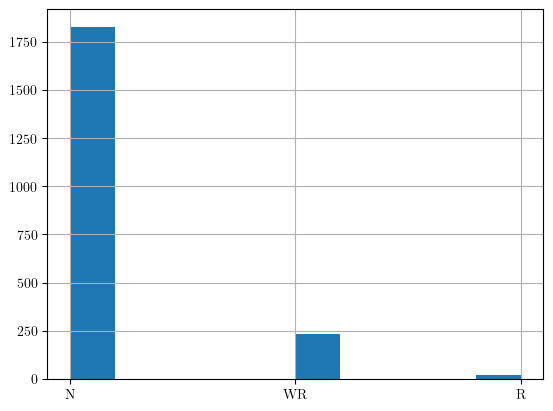

In [35]:
inst.df["weather"].hist()

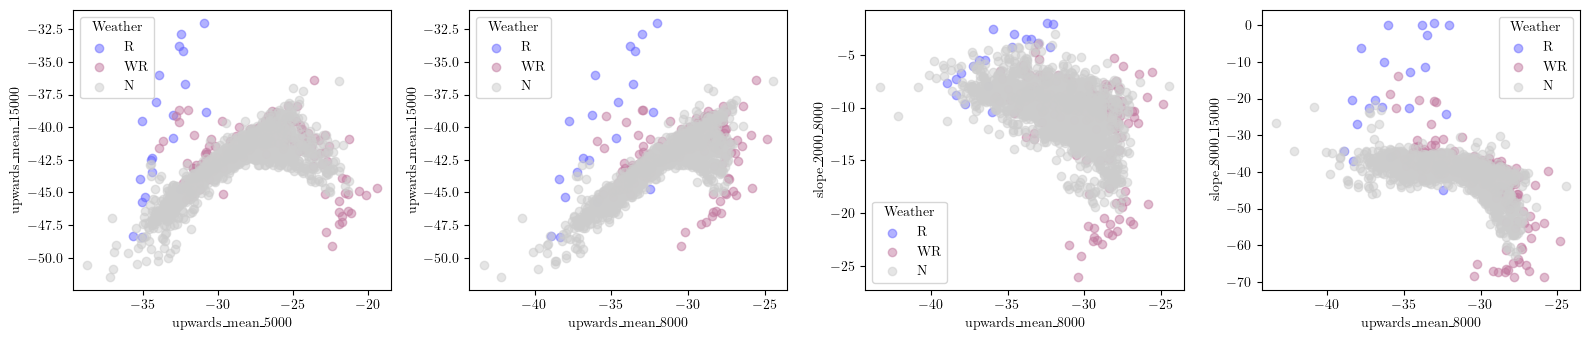

In [36]:
R_Utils.plot_spl_rain(inst.df)

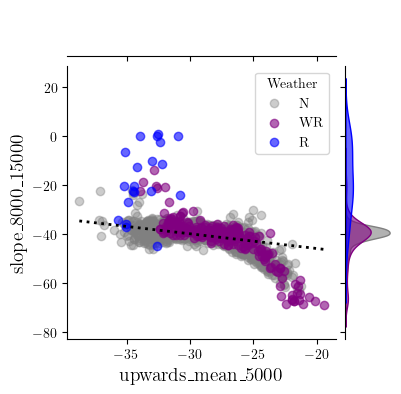

slope_8000_15000 = -0.600949057238999*upwards_mean_5000 - 57.8307924408289
y = -0.6009490572389987 * x + -57.83079244082889


In [37]:
R_Utils.plot_weather_SPL_regression(inst.df,x = "upwards_mean_5000", y = "slope_8000_15000", height=4)

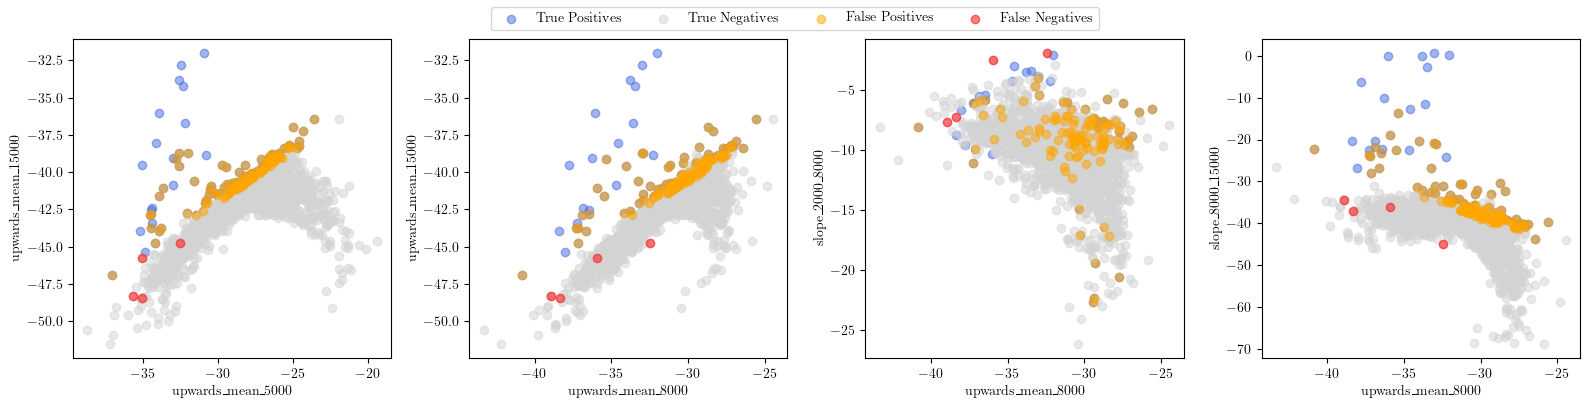

In [38]:
R_Utils.plot_classification_spl(inst.df)

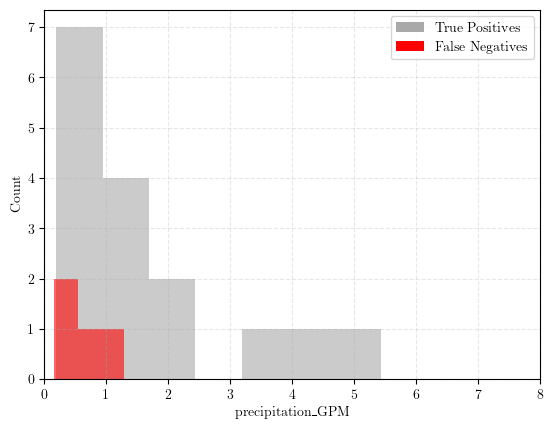

In [39]:
R_Utils.plot_classification_histogram(inst.df)

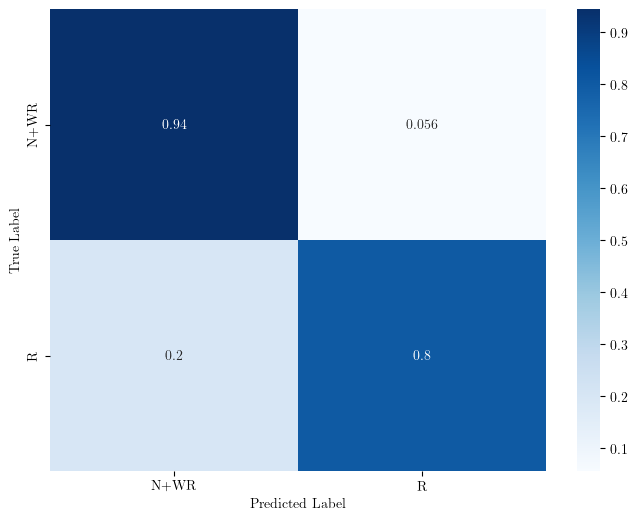

In [40]:
R_Utils.plot_confusion_matrix(inst.df)

### Prec/Recall Curve

100%|██████████| 12/12 [01:52<00:00,  9.37s/it]


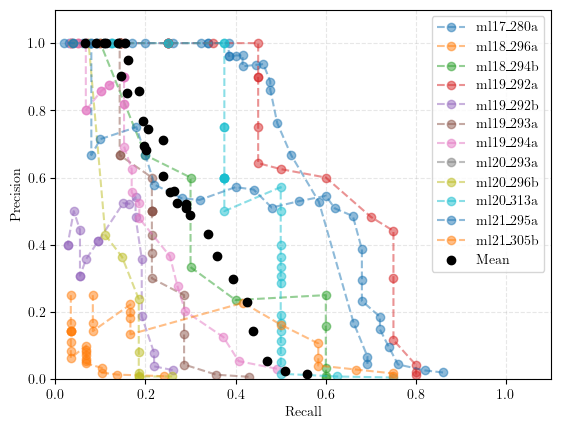

In [11]:
rslts = {}
for depid in tqdm(depids):
    x = []
    y = []

    deps = [depid]
    paths = [path+f"/{depid}" for depid in deps]
    for delta in np.arange(0, 15, 0.5):
        _inst = Rain(depid=deps, path=paths, df_data = 'csv', frequency = 15000, empirical_offset=delta)

        if str(delta) not in rslts:
            rslts[str(delta)] = {"x": [], "y": []}
        precision = sklearn.metrics.precision_score(_inst.df['Rain_Type'], _inst.df['Rain_Type_preds'],pos_label='R', zero_division=0)
        recall = sklearn.metrics.recall_score(_inst.df['Rain_Type'], _inst.df['Rain_Type_preds'],pos_label='R', zero_division=0)

        if recall!= 0 and precision!= 0:
                x.append(recall)
                y.append(precision)
                rslts[str(delta)]["x"].append(recall)
                rslts[str(delta)]["y"].append(precision)
    plt.plot(x, y, linestyle='--', marker='o', label=depid, alpha=0.5)

x_delta_curve = []
y_delta_curve = []
for delta in rslts.keys():
    x_delta_curve.append(np.mean(rslts[delta]["x"]))
    y_delta_curve.append(np.mean(rslts[delta]["y"]))

plt.scatter(x_delta_curve, y_delta_curve, marker="o" , color='black', label='Mean', zorder=5)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.grid(True, linestyle="--", alpha=0.3)

plt.legend()

---
# Estimation
---

In [20]:
# inst.depid_fit(bounds=((0,0),(100,100)))
inst.temporal_fit(bounds=((0,0),(100,100)))
inst.skf_fit(bounds=((0,0),(100,100)),n_splits=8)
print(inst)

Model has been trained with following parameters : 

frequency : upwards_mean_5000
function : <function logRR at 0x000001BE09C27E20>
averaging_duration : 4.5
parameters : {}
ground truth :  IMERG (GPM NASA)
-----------
The model has the following performance :
temporal_mae : 0.47927841985658587
temporal_rmse : 0.49225256449104593
temporal_r2 : -5.727327336607658
temporal_var : 0.04349689386780208
temporal_std : 0.2085590896312172
temporal_cc : -0.09554433797131415
skf_mae : 0.4761122279926947
skf_rmse : 0.660716301220453
skf_r2 : -0.014523995223804431
skf_var : 0.509587369737871
skf_std : 0.6312474273242885
skf_cc : 0.6137715743259072



c:\Users\barsro\.conda\envs\rain\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  warnings.warn(


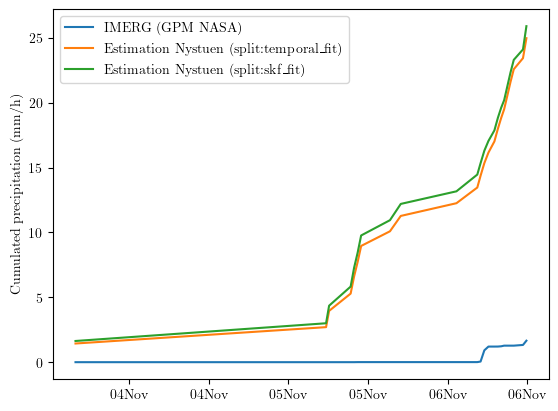

In [21]:
R_Utils.plot_rain_estimation_cumulated(inst, subset="test")

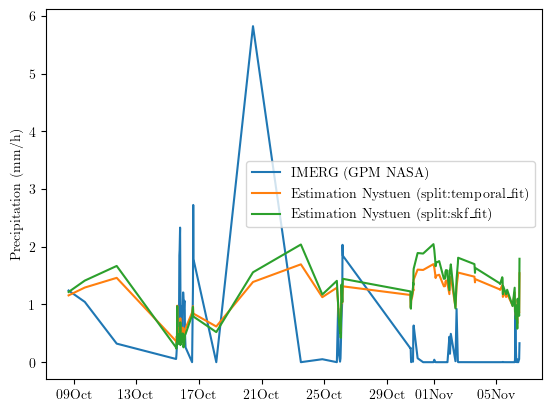

In [22]:
R_Utils.plot_rain_estimation(inst, subset="all")

## Zoom on ml17_280a data 15-16 October 2017

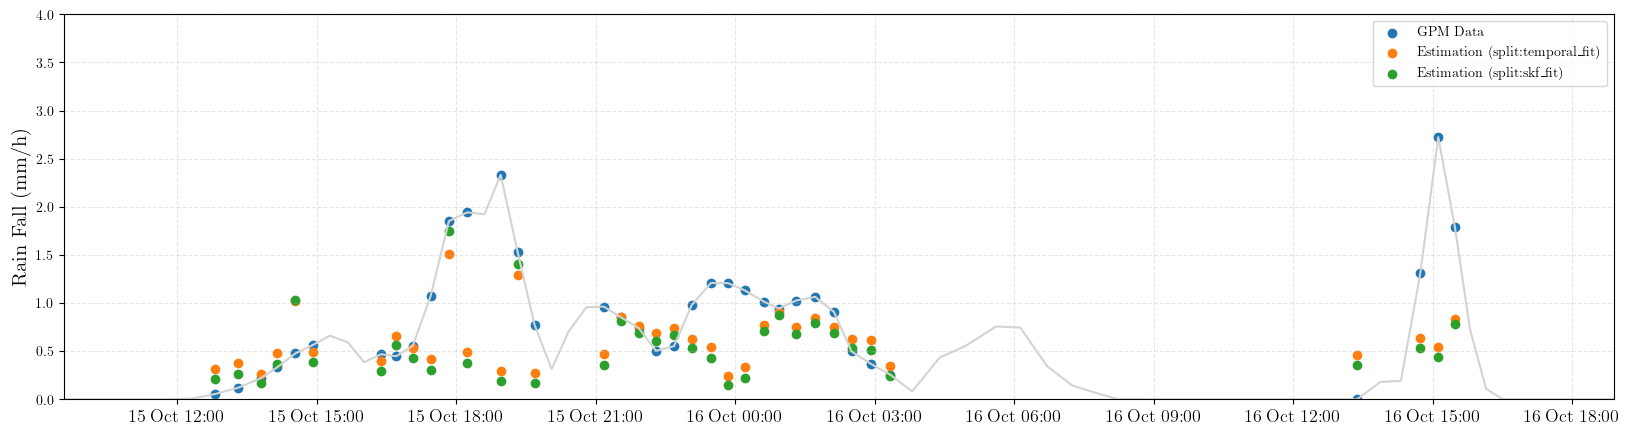

In [23]:
time_dfr = inst.df_r["begin_time"] = pd.to_datetime(inst.df_r["begin_time"], unit='s')
time_df = inst.df["begin_time"] = pd.to_datetime(inst.df["begin_time"], unit='s')

plt.figure(figsize=(20,5))
plt.plot(time_df,inst.df["precipitation_GPM"], c="lightgrey")
plt.scatter(time_dfr,inst.df_r["precipitation_GPM"], label='GPM Data')#, c="royalblue")
for split_rule in inst.popt:
    a,b = inst.popt[split_rule]
    plt.scatter(time_dfr,10**((inst.df_r["upwards_mean_15000"]+a)/b), label=f'Estimation (split:{split_rule})')#, c="lightblue")
plt.ylabel("Rain Fall (mm/h)",fontsize=15)
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %H:%M'))
plt.xlim(pd.to_datetime(6e4 + 1.508e9, unit='s', utc=True),
         pd.to_datetime(1.8e5 + 1.508e9, unit='s', utc=True))
plt.xticks(fontsize=13)
plt.ylim(0,4)
plt.grid(True, linestyle="--", alpha=0.3)
# plt.savefig("../../data-exploration/exports/article/empEst_true_time.pdf")

plt.show()


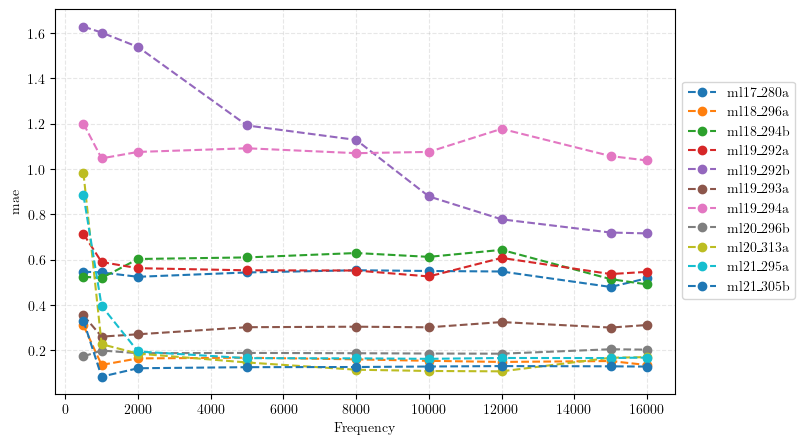

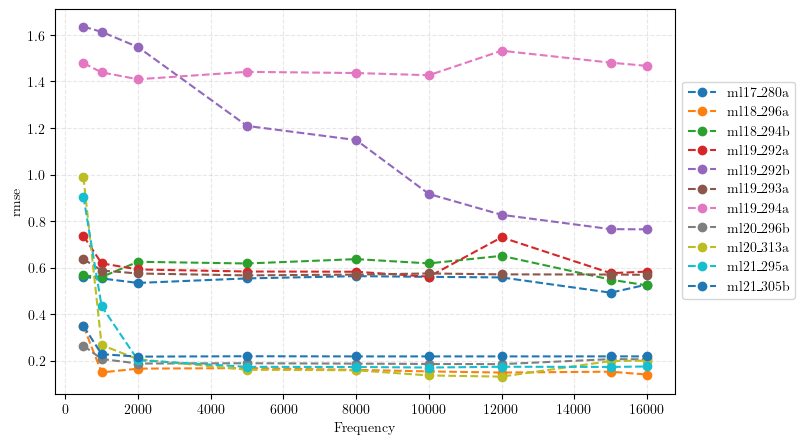

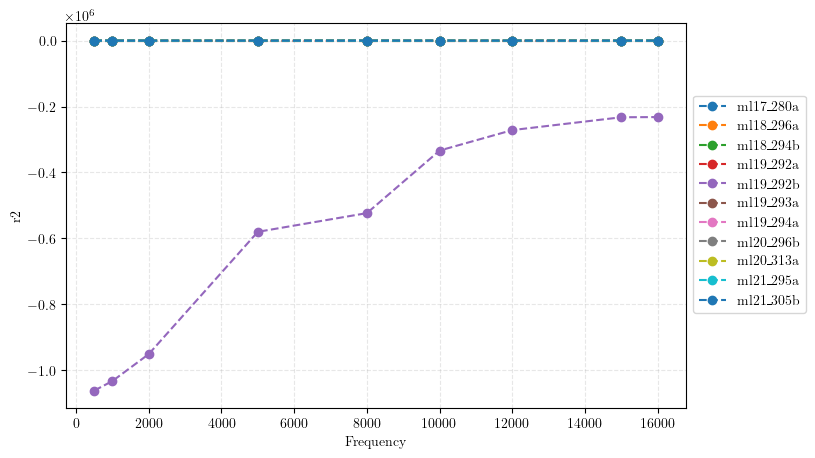

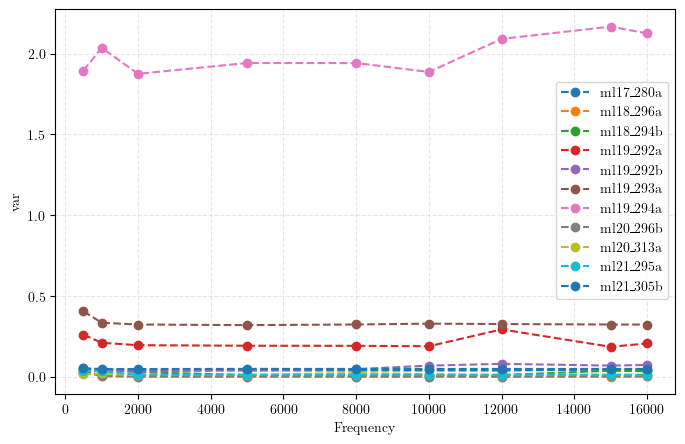

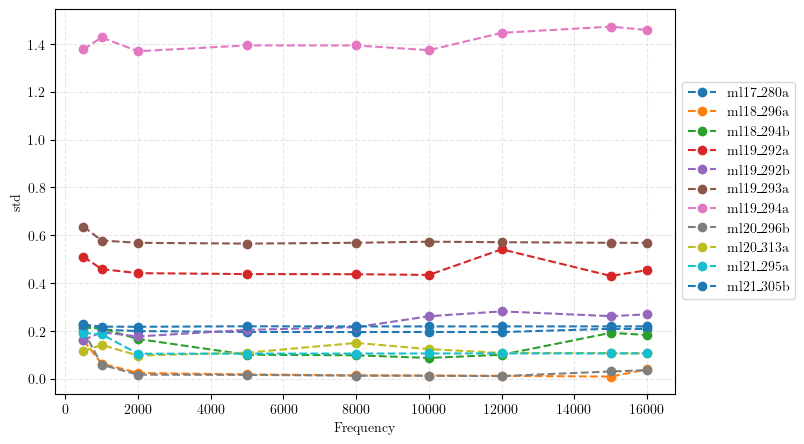

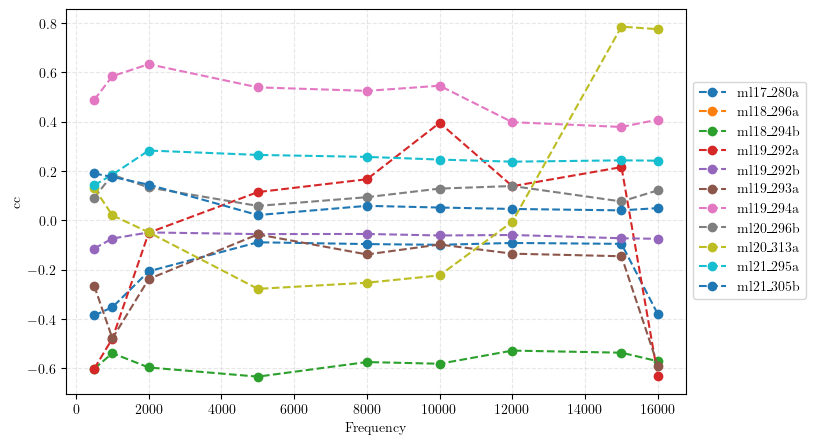

In [18]:
import warnings
warnings.filterwarnings('ignore')

rslts = {}
for depid in depids_wo293:
    rslts[depid]={}
    for freq in freqs :
        rslts[depid][freq] = {}

        deps =[depid]
        paths = [path+f"/{depid}" for depid in deps]

        inst = Rain(depid=deps, path=paths, df_data = 'csv', frequency = freq)
        inst.temporal_fit(bounds=((0,0),(100,100)))
        inst.skf_fit(bounds=((0,0),(100,100)),n_splits=8)
        rslts[depid][freq] = inst.rain_model_stats
        
for metric in ["mae", "rmse","r2","var","std","cc"]:
    plt.figure(figsize=(8, 5))

    for depid in rslts :
        ccs = [rslts[depid][f][f"temporal_{metric}"] for f in freqs]
        plt.plot(freqs, ccs, marker='o', linestyle='dashed', label=depid)#, color='royalblue')
    plt.xlabel('Frequency')
    plt.ylabel(metric)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(bbox_to_anchor=(1, 0.83))
    plt.show()

---
# Miscellaneous
---

---
#### Generation tableau CC Fitted
---

In [33]:
rows = []
for depid in rslts:
    for freq in rslts[depid] :
        # print(freq, rslts[depid][freq]["skf_cc"])
        rows.append({
            "DepID": depid.replace("_", "\\_"),
            "Frequency": freq,
            "CC":rslts[depid][freq]["skf_cc"],
        })

df_long = pd.DataFrame(rows)
table_cc = df_long.pivot(index="Frequency", columns="DepID", values="CC").round(3)

latex_cc = table_cc.to_latex(
    float_format="%.3f",
    caption="$CC$ scores per depid for different frequencies",
    label="tab:cc_by_deployment_fitted",
    escape=False
)

print("=== CC TABLE ===")
print(latex_cc)

=== CC TABLE ===
\begin{table}
\caption{$CC$ scores per depid for different frequencies}
\label{tab:cc_by_deployment_fitted}
\begin{tabular}{lrrrrrrrrrrr}
\toprule
DepID & ml17\_280a & ml18\_294b & ml18\_296a & ml19\_292a & ml19\_292b & ml19\_293a & ml19\_294a & ml20\_296b & ml20\_313a & ml21\_295a & ml21\_305b \\
Frequency &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
500 & 0.159 & -0.608 & 0.827 & -0.428 & 0.636 & -0.909 & 0.249 & -0.130 & 0.285 & 0.062 & 0.628 \\
1000 & 0.341 & -0.596 & 0.578 & -0.413 & 0.842 & -0.898 & 0.314 & -0.313 & -0.097 & 0.068 & 0.698 \\
2000 & 0.438 & -0.866 & 0.883 & -0.117 & 0.892 & -0.416 & 0.546 & -0.145 & -0.105 & 0.238 & 0.456 \\
5000 & 0.469 & -0.960 & 0.778 & 0.128 & 0.943 & -0.101 & 0.606 & 0.050 & 0.872 & 0.283 & -0.016 \\
8000 & 0.453 & -0.976 & 0.830 & 0.204 & 0.932 & -0.188 & 0.635 & 0.107 & 0.877 & 0.261 & -0.018 \\
10000 & 0.525 & -0.964 & 0.858 & 0.539 & 0.919 & -0.200 & 0.669 & 0.154 & 0.899 & 0.239 & -0.047 \\
12000 & 0.535 & -0.911 & 0.888

---
#### Generation tableau CC Biblio
---

In [12]:
rslts = {}
for depid in depids_wo293 :
    rslts[depid] = {}
    for method in ["Nystuen1997","Nystuen2004","Pensieri2015","Nystuen2015"]:
        rslts[depid][method] = {}
        deps = [depid]
        inst = Rain(depid=deps, path=[path+f"/{depid}" for depid in deps], df_data = 'csv', frequency = 15000, method=method)
        inst.estimate_bibliography()
        rslts[depid][method] = inst.rain_model_stats

In [15]:
rows = []
for depid in rslts:
    for method in rslts[depid] :
        rows.append({
            "DepID": depid.replace("_", "\\_"),
            "Method": method,
            "CC":rslts[depid][method]["biblio_cc"],
        })

df_long = pd.DataFrame(rows)
table_cc = df_long.pivot(index="Method", columns="DepID", values="CC").round(3)

latex_cc = table_cc.to_latex(
    float_format="%.3f",
    caption="$CC$ scores per depid for different frequencies",
    label="tab:cc_by_deployment_biblio",
    escape=False
)

print("=== CC TABLE ===")
print(latex_cc)

=== CC TABLE ===
\begin{table}
\caption{$CC$ scores per depid for different frequencies}
\label{tab:cc_by_deployment_biblio}
\begin{tabular}{lrrrrrrrrrrr}
\toprule
DepID & ml17\_280a & ml18\_294b & ml18\_296a & ml19\_292a & ml19\_292b & ml19\_293a & ml19\_294a & ml20\_296b & ml20\_313a & ml21\_295a & ml21\_305b \\
Method &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Nystuen1997 & -0.241 & 0.044 & 0.037 & -0.173 & 0.034 & 0.080 & 0.327 & -0.071 & 0.121 & -0.014 & 0.080 \\
Nystuen2004 & -0.246 & 0.069 & 0.014 & -0.197 & 0.108 & 0.085 & 0.353 & -0.107 & 0.143 & -0.003 & 0.079 \\
Nystuen2015 & -0.252 & 0.097 & -0.001 & -0.217 & 0.227 & 0.079 & 0.377 & -0.144 & 0.162 & 0.041 & 0.077 \\
Pensieri2015 & -0.251 & 0.090 & 0.001 & -0.213 & 0.202 & 0.082 & 0.372 & -0.136 & 0.158 & 0.027 & 0.078 \\
\bottomrule
\end{tabular}
\end{table}

